# Experiments

notebook includes experiments using `deepseek-r1-distill-qween-7b`, `o3-mini-2025-01-31`, and `gemini-2.0-flash`

metrics:
- `deepseek-r1-distill-qween-7b`:
    - cost: Free, open sourced running locally
    - rate limits:
        - no rate limits since running locally
        - context length: 4096 tokens per prompt
        - 7B paramter pre trained model

- `o3-mini-2025-01-31`:
    - cost: $1.1 per 1M tokens
    - rate limits:
        - requests per minute: 1,000
        - tokens per minute: 100,000
    - check openai balance: https://platform.openai.com/settings/organization/billing/overview

- `gemini-2.0-flash`:
    - cost: Free tier
    - rate limits:
        - requests per minute: 15
        - tokens per minute: 1,000,000
        - requests per day: 1,500

## Define Run Tests Function

### Define API calls to models

In [1]:
from openai import OpenAI
import requests
from google import genai
import os
import time
import pandas as pd
client = OpenAI()

def gpt(messages=[{
            "role": "user",
            "content": "Write a one-sentence bedtime story about a unicorn."
        }]):
    start_time = time.time()
    
    completion = client.chat.completions.create(
        model="o3-mini-2025-01-31",
        messages=messages
    )
    end_time = time.time()
    elapsed_time = end_time - start_time

    return (completion.choices[0].message.content, elapsed_time)

def gemini(message="Explain how AI works"):
    client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
    
    start_time = time.time()
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=message,
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return (response.text, elapsed_time)

def deepseek(messages=[
          { "role": "system", "content": "Always answer in rhymes. Today is Thursday" },
          { "role": "user", "content": "What day is it today?" }
        ]):
    '''
        curl example: 
        curl http://localhost:1234/v1/chat/completions \
          -H "Content-Type: application/json" \
          -d '{
            "model": "deepseek-r1-distill-qwen-7b",
            "messages": [
              { "role": "system", "content": "Always answer in rhymes. Today is Thursday" },
              { "role": "user", "content": "What day is it today?" }
            ],
            "temperature": 0.7,
            "max_tokens": -1,
            "stream": false
        }'
    '''
    request = {
        "model": "deepseek-r1-distill-qwen-7b",
        "messages": messages,
        "temperature": 0.7,
        "max_tokens": -1,
        "stream": False
    }
    
    start_time = time.time()
    response = requests.post('http://localhost:1234/v1/chat/completions', json=request)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if response.status_code == 200:
        return (response.json()['choices'][0]['message']['content'], elapsed_time)
    else:
        return (response.text, elapsed_time)

### Run Models Function

In [2]:
''' def run_gpt(responses, times, p):
    gpt_response = gpt(messages=[{'role': 'user', 'content': p}])
    responses.append(gpt_response[0])
    times.append(gpt_response[1])
'''

def run_models(responses, times, p):
    gpt_response = gpt(messages=[{'role': 'user', 'content': p}])
    responses[0].append(gpt_response[0])
    times[0].append(gpt_response[1])

    deepseek_response = deepseek(messages=[{'role': 'user', 'content': p}])
    responses[1].append(deepseek_response[0])
    times[1].append(deepseek_response[1])

    gemini_response = gemini(message=p)
    responses[2].append(gemini_response[0])
    times[2].append(gemini_response[1])

### Generate Plots Function

In [3]:
from IPython.display import display, Markdown
import pandas as pd
import re

'''
def generate_gpt_table(test_name, prompts, responses, times):
    # init data frame with model response lists
    test_results_df = pd.DataFrame({
        'Prompt': prompts,
        'GPT': responses,
        'GPT Time': times,
    })

    print(f"{test_name} results:")
    display(Markdown(test_results_df.to_markdown()))
'''

def generate_table(test_name, prompts, responses, times):
    # init data frame with model response lists
    test_results_df = pd.DataFrame({
        'Prompt': prompts,
        'GPT': responses[0],
        'GPT Time': times[0],
        'Deepseek': responses[1],
        'Deepseek Time': times[1],
        'Gemini': responses[2],
        'Gemini Time': times[2],
    })
    
    # clean cells, remove think tags from deepseek and remove new lines
    def remove_think_tags(cell):
        if isinstance(cell, str): 
            cell = re.sub(r'<think>.*?</think>', '', cell, flags=re.DOTALL)
            cell = cell.replace('\n', ' ')
        return cell

    # apply filters and render in markdown
    def render_dataframe_as_markdown(df):
        df_cleaned = df.map(remove_think_tags)
        display(Markdown(df_cleaned.to_markdown()))

    print(f"{test_name} results:")
    render_dataframe_as_markdown(test_results_df)

### Wrapped Function

In [4]:
'''
def run_gpt_tests(test_name, prompts):
    responses = []
    times = []
    print(f"gpt o3-mini warming up for {test_name}")
    for p in prompts:
        run_gpt(responses, times, p)
    print(f"gpt inferencing finished for {test_name}")
    generate_gpt_table(test_name, prompts, responses, times)
    return responses, times
'''

def run_tests_e2e(test_name, prompts):
    # ind 0 is gpt, 1 is deepsek, 2 is gemini
    responses = [[],[],[]]
    times = [[],[],[]]
    print(f"models warming up for {test_name}")
    for p in prompts:
        run_models(responses, times, p)
    print(f"models inferencing finished for {test_name}")
    generate_table(test_name, prompts, responses, times)
    return responses, times

## AI explainability and interpretability prompts (White Box)

In [5]:
retrieval_prompts = [
    "How many points did Lebron James score on October 18th, 2018 against the Portland Trailblazers?",
    "How many championships has Steph Curry won in his career?",
    "How many games did Andre Iguodala miss in the 2016-2017 regular season?",
    "What were the top 3 overall teams in terms of standings at the end of the 1996-1997 regular season?"
]

reasoning_prompts = [
    "What do you get if you add Lebron James career point total with Kobe Bryant's career points total?",
    "If you take the Miami Heat's regular season seed standing in the 2013 season compared to their seed in the 2010 season what is the difference?",
    "If you add Micheal Jordan's and Wilt Chamberlain's highest scoring games point total together, what do you get?",
    "How many combined MVP awards do Russell Westbrook and Kareem Abdul-Jabbar have?"
]

long_prompts = [
    '''
    Consider two elite scorers from the 2022-2023 NBA season: Joel Embiid and Luka Dončić. Embiid won the scoring title averaging 33.1 PPG
    on 54.8% FG and 65.5% True Shooting (TS%). Dončić averaged 32.4 PPG on 49.6% FG and 60.9% TS%. Both players had extremely high usage rates,
    dominating the ball for their respective teams, the 76ers and Mavericks. Embiid primarily operated from the post and midrange, while Dončić
    heavily relied on step-back threes and drives. Based purely on the provided PPG and efficiency metrics (FG%, TS%), which player scored more
    efficiently during this season? Briefly explain what TS% tells us compared to just FG% in this context.
    ''',
    '''
    Let's look at the Memphis Grizzlies. In the 2021-2022 season, they finished with the 4th best Offensive Rating (114.3) and 6th best
    Defensive Rating (108.9), playing at the 3rd fastest Pace (101.02). They relied heavily on Ja Morant's drives, offensive rebounding,
    and transition offense. The following season, 2022-2023, their Offensive Rating was 11th (114.7), Defensive Rating improved to 3rd 
    (110.7), and Pace remained high at 3rd (101.33). Despite Morant missing significant time, their defense anchored by Jaren Jackson Jr. 
    became more dominant. Did the Grizzlies become a better overall team based on net rating (Off Rating - Def Rating)? How did their
    identity slightly shift between these two seasons according to these ratings and ranks?
    ''',
    ''' 
    Nikola Jokić finished the 2022-2023 NBA season with a Value Over Replacement Player (VORP) rating of 8.8, leading the league. 
    VORP is an estimate of a player's overall contribution to the team, measured in points per 100 team possessions, translated into 
    wins above what a readily available 'replacement-level' player would provide over the season. Jokić also averaged impressive 
    traditional stats: 24.5 points, 11.8 rebounds, and 9.8 assists per game. How does his league-leading VORP score add context to his 
    traditional stats? What does a VORP of 8.8 specifically suggest about his value to the Denver Nuggets that season?
    ''',
    '''
    In the 2023-2024 season, consider Tyrese Haliburton of the Indiana Pacers and Anthony Davis of the Los Angeles Lakers. Haliburton
    led the league in assists per game (10.9 APG) while scoring 20.1 PPG on efficient shooting splits (47.7% FG / 36.4% 3P / 85.5% FT). 
    Anthony Davis, playing primarily center/power forward, averaged 24.7 PPG, 12.6 RPG (3rd in NBA), and 2.3 BPG (4th in NBA). Both 
    players were critical to their teams' success. Based on these specific stats (PPG, APG, RPG, BPG), contrast the primary roles these
    two All-Stars fulfilled for their respective teams during that season.
    '''
]

# _, retrieval_times = run_tests_e2e("retrieval test", retrieval_prompts)
# _, reasoning_times = run_tests_e2e("reasoning test", reasoning_prompts)
retrieval_responses, retrieval_times = run_tests_e2e("retrival test", retrieval_prompts)
reasoning_responses, reasoning_times = run_tests_e2e("reasoning test", reasoning_prompts)
long_responses, long_times = run_tests_e2e("long prompt test", long_prompts)

models warming up for retrival test
models inferencing finished for retrival test
retrival test results:


|    | Prompt                                                                                              | GPT                                                                                                                                                                                                                                                                                                                                                                                                                                  |   GPT Time | Deepseek                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |   Deepseek Time | Gemini                                                                                                                                                                    |   Gemini Time |
|---:|:----------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------:|
|  0 | How many points did Lebron James score on October 18th, 2018 against the Portland Trailblazers?     | On October 18, 2018, LeBron James scored 51 points against the Portland Trail Blazers.                                                                                                                                                                                                                                                                                                                                               |    8.6243  | LeBron James scored **25 points** on October 18, 2018, against the Portland Trail Blazers during a blowout victory for the Cavaliers. This game was part of the regular season and highlighted his developing scoring ability despite playing against a strong opponent.  **Step-by-Step Explanation:**  1. **Identify the Date and Opponent:** The question is about October 18, 2018, against the Portland Trail Blazers.     2. **Recall or Research Game Details:** Lebron James played for the Cleveland Cavaliers during this period. It's known that he had a significant performance in his career againstPortland.  3. **Determine the Score:** Upon checking historical records, it was found that LeBron scored 25 points in this game. The Cavaliers won with a score of 123-97, indicating a high-scoring game and Lebron's contribution to the team's offense.  4. **Conclusion:** Therefore, Leviathan James scored 25 points on October 18, 2018, against the Portland Trail Blazers during the regular season.  **Answer:** LeBron James scored 25 points on October 18th, 2018, against thePortland Trail Blazers. |        28.8723  | LeBron James scored **26 points** on October 18th, 2018 against the Portland Trail Blazers.                                                                               |      0.615105 |
|  1 | How many championships has Steph Curry won in his career?                                           | Steph Curry has won four NBA championships in his career. He achieved these titles with the Golden State Warriors in the following seasons: 2015, 2017, 2018, and 2022.                                                                                                                                                                                                                                                              |    4.30914 | Steph Curry has won one NBA championship during his career. He achieved this by leading the Golden State Warriors to victory in the 2015 NBA Finals against the Cleveland Cavaliers.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |         8.51031 | Steph Curry has won **4 NBA championships**.                                                                                                                              |      0.5452   |
|  2 | How many games did Andre Iguodala miss in the 2016-2017 regular season?                             | Andre Iguodala appeared in 77 of the 82 regular‐season games during the 2016–17 season. In other words, he missed 5 games that year.  Note: This answer is based on the official game logs and records from that season. If you consult sources such as Basketball-Reference or the NBA’s official stats for the 2016–17 season, you will find that Iguodala’s 77-game mark implies he sat out 5 contests during the regular season. |   27.3589  | Andre Iguodala missed approximately 4 games in the 2016-2017 NBA regular season due to a strained right quadriceps muscle, as reported by credible news outlets. This injury necessitated his sit-out period while he recovered, impacting his playing minutes and overall participation in the season.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |        14.9698  | Andre Iguodala missed **6** games in the 2016-2017 regular season.                                                                                                        |      0.468061 |
|  3 | What were the top 3 overall teams in terms of standings at the end of the 1996-1997 regular season? | Could you please clarify which sport or league’s 1996–1997 regular season you’re referring to? For example, are you asking about the NBA, NHL, or another competition?                                                                                                                                                                                                                                                               |    8.82375 | The top three NBA teams at the end of the 1996-97 regular season were:  1. **Chicago Bulls**: Known for Michael Jordan's leadership and a strong roster featuring players like Olajuwon and Hedo. 2. **Los Angeles Lakers**: Dominated under coach David Stern, with key stars like Kobe Bryant and Magic Johnson contributing to their success. 3. **Dallas Mavericks**: Noted for their strategic use of small ball and standout performance under coach Daryl Morey.  These teams stood out as the most prominent during that season.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |        18.1876  | The top 3 teams in the NBA standings at the end of the 1996-1997 regular season were:  1.  **Chicago Bulls (69-13)** 2.  **Utah Jazz (64-18)** 3.  **Miami Heat (61-21)** |      0.845196 |

models warming up for reasoning test
models inferencing finished for reasoning test
reasoning test results:


|    | Prompt                                                                                                                                         | GPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |   GPT Time | Deepseek                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |   Deepseek Time | Gemini                                                                                                                                                                                                        |   Gemini Time |
|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------:|
|  0 | What do you get if you add Lebron James career point total with Kobe Bryant's career points total?                                             | Keep in mind that Kobe Bryant’s career is finished while LeBron James is still adding to his totals, so any “sum” will depend on which snapshot you use for LeBron’s points. However, here’s one way to break it down using widely cited figures:  • Kobe Bryant’s official NBA career total is 33,643 points.   • As of recent updates, LeBron James has passed the 38,000‐point mark (for example, many sources note a figure in the low-to-mid 38,000s).    If we use an often cited figure of about 38,000 for LeBron (knowing that his total increases with every game), the combined total would be roughly:   33,643 (Kobe) + 38,000 (LeBron) = about 71,643 points.  If you use a more precise recent total for LeBron—say, approximately 38,652 points—then the sum becomes:   33,643 + 38,652 = 72,295 points.  So, depending on which LeBron total you use, you get somewhere in the ballpark of 72,000 career points combined. Just remember that because LeBron is still active, his total (and consequently the combined total) will continue to grow over time. |   24.0465  | The combined career point totals of LeBron James and Kobe Bryant amount to approximately 4.0 million points.                                                                                                                                                                                                                                                                                                                                                                                                                                                 |          8.7046 | As of October 6, 2024:  *   LeBron James' career point total is approximately 40,474 *   Kobe Bryant's career point total is 33,643  Adding these together: 40,474 + 33,643 = 74,117  So the answer is 74,117 |      0.928908 |
|  1 | If you take the Miami Heat's regular season seed standing in the 2013 season compared to their seed in the 2010 season what is the difference? | In the 2013 season the Heat finished as the No. 1 seed in the Eastern Conference, while in the 2009–10 season (often referred to by its concluding year, 2010) they earned the No. 5 seed. That means the difference between their regular‐season playoff seeding in these two seasons is 4 seed positions.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |   19.0479  | The Miami Heat's seeding in the 2013-2014 NBA season was first place in the Eastern Conference, while in the 2010-2011 season, they were second place. Therefore, the difference in their regular season seed standing is one spot improvement from second to first.   Answer: The Miami Heat's seeding improved by one position from 2010 to 2013, moving from second place to first place.                                                                                                                                                                 |         13.8167 | *   **2013 Season:** The Miami Heat were the **1st** seed in the Eastern Conference. *   **2010 Season:** The Miami Heat were the **5th** seed in the Eastern Conference.  The difference is 5 - 1 = **4**.   |      0.751986 |
|  2 | If you add Micheal Jordan's and Wilt Chamberlain's highest scoring games point total together, what do you get?                                | Michael Jordan’s highest-scoring game was 69 points (achieved in a regular season game against the Cleveland Cavaliers), and Wilt Chamberlain’s famous 100‐point game is well known. Adding them together, 69 + 100 equals 169 points.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |    6.72253 | The combined point totals of Michael Jordan's and Wilt Chamberlain's highest scoring games are calculated by adding their individual maximum scores:  Michael Jordan scored 96 points in his highest game, while Wilt Chamberlain scored 108 points.   Adding these together:  \[ 96 + 108 = 204 \]  **Answer:** The combined total is 204 points.                                                                                                                                                                                                           |         32.8768 | *   Michael Jordan's highest scoring game: 69 points *   Wilt Chamberlain's highest scoring game: 100 points  Adding them together: 69 + 100 = 169  Therefore, the answer is $\boxed{169}$.                   |      0.756829 |
|  3 | How many combined MVP awards do Russell Westbrook and Kareem Abdul-Jabbar have?                                                                | Kareem Abdul-Jabbar won 6 regular‐season MVP awards in his career, while Russell Westbrook has not won a regular‐season MVP. So, between the two, they have a combined total of 6 MVP trophies.  Note: • When people refer to “MVP awards” in the context of NBA accolades, they’re usually talking about the NBA’s regular‐season Most Valuable Player Award. While Westbrook has earned many honors (including NBA All-Star selections and even an All-Star Game MVP), he has not won the regular‐season MVP award.  Therefore, the answer is 6.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |   19.1261  | Russell Westbrook has won the MVP award twice—during the 2017-18 season when the Oklahoma City Thunder won their first NBA Championship, and again during the 2019-20 season for their championship victory. Kareem Abdul-Jabbar, on the other hand, did not win any MVP awards throughout his career, as he primarily played with teams that were in the process of building up talent rather than winning championships.  **Answer:** Russell Westbrook has 2 MVP awards, while Kareem Abdul-Jabbar has none. Combined, they have a total of 2 MVP awards. |         11.9238 | *   **Russell Westbrook:** 1 MVP award (2017) *   **Kareem Abdul-Jabbar:** 6 MVP awards (1971, 1972, 1974, 1976, 1977, 1980)  Together, they have 1 + 6 = **7** MVP awards.                                   |      0.927709 |

models warming up for long prompt test
models inferencing finished for long prompt test
long prompt test results:


|    | Prompt                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | GPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |   GPT Time | Deepseek                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |   Deepseek Time | Gemini                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |   Gemini Time |
|---:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------:|
|  0 | Consider two elite scorers from the 2022-2023 NBA season: Joel Embiid and Luka Dončić. Embiid won the scoring title averaging 33.1 PPG     on 54.8% FG and 65.5% True Shooting (TS%). Dončić averaged 32.4 PPG on 49.6% FG and 60.9% TS%. Both players had extremely high usage rates,     dominating the ball for their respective teams, the 76ers and Mavericks. Embiid primarily operated from the post and midrange, while Dončić     heavily relied on step-back threes and drives. Based purely on the provided PPG and efficiency metrics (FG%, TS%), which player scored more     efficiently during this season? Briefly explain what TS% tells us compared to just FG% in this context.                                                                                                | Based on TS% (True Shooting Percentage), Joel Embiid scored more efficiently than Luka Dončić. Embiid’s TS% of 65.5% is notably higher than Dončić’s 60.9%, even though their points per game are similar.   To elaborate, FG% (Field Goal Percentage) only measures the percentage of shots made from the field, without considering the value of different shot types or free throws. TS%, on the other hand, incorporates field goals, three-point shots, and free throws into a single metric, reflecting the overall scoring efficiency regardless of shot type. This makes TS% a more comprehensive indicator of a player’s scoring efficiency since it accounts for the extra value of three-pointers and the points added through free throws.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |    3.67444 | Based on the analysis of Joel Embiid and Luka Dončić's performance using PPG, FG%, and TS%, Joel Embiid demonstrated greater efficiency during the 2022-2023 NBA season. Here's a structured breakdown:  1. **Points Per Game (PPG):**      - Embiid led with 33.1 PPG.    - Dončić followed closely with 32.4 PPG.  2. **Field Goal Percentage (FG%):**      - Embiid shot at 54.8%, higher than Dončić's 49.6%.  3. **True Shooting Percentage (TS%):**      - Embiid excelled with a TS% of 65.5%, compared to Dončić's 60.9%.      - TS% is crucial as it accounts for the value of three-pointers, making Embiid's higher percentage indicative of better overall efficiency.  Conclusion: Despite slightly lower PPG and FG%, Joel Embiid was more efficient due to his superior True Shooting Percentage, suggesting that each shot he attempted was more effective than Dončić's.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |         19.1619 | Based purely on the provided PPG and efficiency metrics (FG%, TS%), **Joel Embiid scored more efficiently** during the 2022-2023 season.  While their PPG was close, Embiid had a significantly higher field goal percentage (54.8% vs. 49.6%) and a higher True Shooting percentage (65.5% vs. 60.9%).  **TS% tells us more than FG% because it accounts for the value of three-point shots and free throws.** FG% only considers how often a player makes a shot from the field, regardless of whether it's a two-pointer or a three-pointer. TS%, on the other hand, factors in both the frequency of shots made from the field, the added value of three-pointers, and the player's free throw percentage, all rolled into one overall shooting efficiency percentage. This gives a more complete picture of a player's scoring efficiency, especially in an era where three-pointers and drawing fouls are significant parts of the game.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |       1.53577 |
|  1 | Let's look at the Memphis Grizzlies. In the 2021-2022 season, they finished with the 4th best Offensive Rating (114.3) and 6th best     Defensive Rating (108.9), playing at the 3rd fastest Pace (101.02). They relied heavily on Ja Morant's drives, offensive rebounding,     and transition offense. The following season, 2022-2023, their Offensive Rating was 11th (114.7), Defensive Rating improved to 3rd      (110.7), and Pace remained high at 3rd (101.33). Despite Morant missing significant time, their defense anchored by Jaren Jackson Jr.      became more dominant. Did the Grizzlies become a better overall team based on net rating (Off Rating - Def Rating)? How did their     identity slightly shift between these two seasons according to these ratings and ranks? | Looking at the numbers, one can draw two major conclusions.  1. Net Rating and Overall Improvement:  • In 2021–2022 the Grizzlies had an Offensive Rating of 114.3 and a Defensive Rating of 108.9, which gives a net rating of about +5.4.  • In 2022–2023 the Offensive Rating was slightly up at 114.7 but the Defensive Rating was also higher at 110.7, yielding a net rating of roughly +4.0.  • In terms of net rating—a quick proxy for overall performance—the team’s margin decreased by about 1.4 points. So even though the raw offensive number nudged up, being outpaced (and by league comparison, dropping from 4th best offense to 11th) along with allowing more points per 100 possessions (despite a better “rank” as 3rd best defense) indicates that the Grizzlies did not improve overall as measured by net rating.  2. Shifting Team Identity:  • In 2021–2022 the team’s identity was largely built around Ja Morant’s explosive drives, rebounding on the offensive end, and an emphasis on transition offense. Their high-paced play (3rd fastest pace) helped them capitalize on these strengths.  • In the following season, even with Morant missing significant time, the Grizzlies leaned more on a defensive identity anchored by Jaren Jackson Jr. Even though the defensive numbers may appear nominally worse in terms of the raw number (110.7 vs. 108.9), a move in the rankings (from 6th best defense to 3rd best) suggests that, relative to the rest of the league, their defensive impact became more prominent.  • On the offensive side, while the overall rating barely moved (114.3 to 114.7), the shift in league ranking (from 4th to 11th) implies that other teams improved their offenses, making the Grizzlies’ attack relatively less potent. In effect, the offense might have taken a back seat to the defensive recalibration.  • Thus, the team’s identity moderated from a high-octane, Morant-led, transition and rebounding machine to a more balanced unit that, in the absence of its full offensive superstar load, put greater emphasis on defensive strength and team play.  In summary, while the Memphis Grizzlies’ net rating dipped slightly from +5.4 to +4.0, they shifted their identity away from an overwhelming reliance on explosive, individual offense toward a more balanced approach where an improved, collectively dominant defense became a key part of their strategy. |   16.8131  | The Memphis Grizzlies' performance from the 2021-2022 season to the 2022-2023 season can be evaluated through their offensive and defensive ratings as well as net rating. Here's a structured analysis:  1. **Net Rating Analysis:**    - **2021-2022 Season:** Net Rating = 5.4 (Offensive Rating 114.3 - Defensive Rating 108.9)    - **2022-2023 Season:** Net Rating = 4 (Offensive Rating 114.7 - Defensive Rating 110.7)        Despite a slight decrease in net rating, the Grizzlies saw significant improvements in their defensive ratings.  2. **Change in Offensive and Defensive Ratings:**    - **Offensive Rating:** Remained stable at 114.3 to 114.7.    - **Defensive Rating:** Improved from 108.9 to 110.7, reflecting a strong defensive performance.  3. **Impact of Key Players:**    - **Ja Morant's Absence:** His significant time away affected offensive contributions, but the team relied more on defensive strategies.    - **Jaren Jackson Jr.:** His leadership and role in defense contributed to stronger defensive ratings without relying heavily onMorant's offense.  4. **Pace of Play:**    - Both seasons had similar pace ratings (101.02 for 2021-2022, 101.33 for 2022-2023), indicating consistent playstyle.  5. **Conclusion on Overall Team Performance:**    - While net rating decreased slightly from 5.4 to 4, the substantial improvement in defensive ratings suggests that the Grizzlies may have overall improved due to enhanced defense, potentially outweighing minor offensive losses.  In summary, though net rating indicated a slight decline, the Grizzlies likely experienced better overall performance with stronger defenses and strategic shifts towards more defensive-oriented play led by Jaren Jackson Jr. |         23.9337 | Okay, let's analyze the Memphis Grizzlies' performance shift between the 2021-2022 and 2022-2023 seasons based on the provided data.  **1. Did the Grizzlies become a better overall team based on Net Rating?**  *   **2021-2022 Net Rating:** 114.3 (Offensive Rating) - 108.9 (Defensive Rating) = **5.4** *   **2022-2023 Net Rating:** 114.7 (Offensive Rating) - 110.7 (Defensive Rating) = **4.0**  Based on Net Rating alone, the Grizzlies were *not* a better overall team in 2022-2023. Their net rating decreased from 5.4 to 4.0.  **2. How did their identity slightly shift?**  *   **2021-2022:**     *   **Emphasis:** High-powered, fast-paced offense, fueled by Ja Morant's athleticism and playmaking. Above average defense.     *   **Strengths (based on context):**  Strong transition game, offensive rebounding (contributing to pace and scoring), and Ja Morant's drives to the basket.     *   **Off Rating Rank**: 4th     *   **Def Rating Rank**: 6th  *   **2022-2023:**     *   **Emphasis:**  Defense became more of a focal point, while the offense became a bit less potent, especially with Morant's absence. Still maintained a very fast pace.     *   **Strengths (based on context):** Jaren Jackson Jr. as a defensive anchor. Team defense in general was a strength this season.     *   **Off Rating Rank**: 11th     *   **Def Rating Rank**: 3rd  **In summary, the identity shift was from a high-octane offensive team with decent defense to a defensively stout team that still pushed the pace but was less potent offensively.**  **Key takeaways from the shift:**  *   **Defense Took Priority:** The improvement in defensive rating and ranking is the most significant change. This suggests a coaching adjustment, improved player development, and/or a greater emphasis on defensive schemes and effort. Jaren Jackson Jr.'s growth is clearly a major factor. *   **Offensive Adaptation:** The slight dip in offensive rating and ranking indicates that the team struggled to maintain the same offensive output without Ja Morant for stretches. They still scored efficiently, but the volume and ease of scoring may have diminished. They likely adapted their offensive schemes to rely less on Morant's individual brilliance and more on other players and ball movement. *   **Pace Maintained:** The Grizzlies retained their fast pace, demonstrating a commitment to running and transition even without their primary ball-handler. This could be a strategic decision to try and outrun opponents even if their half-court offense wasn't as dominant. *   **Net Rating Caveat:** While the net rating decreased, it's important to consider the context of Morant's absence.  The team may have been a similar or even better *overall* team in terms of potential, but Morant's absence meant that they didn't realize that potential in terms of season long net rating.                                                                                                                                                                                                                                           |       4.83631 |
|  2 | Nikola Jokić finished the 2022-2023 NBA season with a Value Over Replacement Player (VORP) rating of 8.8, leading the league.      VORP is an estimate of a player's overall contribution to the team, measured in points per 100 team possessions, translated into      wins above what a readily available 'replacement-level' player would provide over the season. Jokić also averaged impressive      traditional stats: 24.5 points, 11.8 rebounds, and 9.8 assists per game. How does his league-leading VORP score add context to his      traditional stats? What does a VORP of 8.8 specifically suggest about his value to the Denver Nuggets that season?                                                                                                                             | VORP puts Nikola Jokić’s traditional stats into a broader team-impact perspective. While the box score numbers (24.5 points, 11.8 rebounds, and 9.8 assists per game) show his impressive offensive and all-around game, the VORP of 8.8 quantifies just how much better the Nuggets performed with him on the court relative to what they’d expect from a “replacement-level” player. In other words:  • A VORP of 8.8 means that over the season, Jokić provided about 8.8 extra wins for the Nuggets compared to if they had used an average bench or fringe player instead.   • It takes into account not just the easy-to-measure scoring stats but also all the intangibles and contextual contributions—like floor spacing, decision-making, and the way his play influences teammates.   • Leading the league in VORP demonstrates that his overall influence on the team’s success was unmatched. It tells us that his all-around game was so effective that his presence elevated the Nuggets’ performance significantly beyond what his raw numbers might hint at on their own.  Thus, while his traditional stats highlight his skill set, the league-leading VORP of 8.8 underscores that he was not only putting up great numbers but was a key win generator for the team, making him exceptionally valuable for the Denver Nuggets that season.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |    8.56206 | Nikola Jokić's impressive season with the Denver Nuggets can be comprehensively evaluated using his traditional stats and VORP score:  1. **Traditional Stats Overview:**    - Jokić averaged 24.5 points, 11.8 rebounds, and 9.8 assists per game.    - These numbers highlight his exceptional scoring ability, strong offensive presence, and effective playmaking skills.  2. **Context from VORP Score (8.8):**    - A VORP of 8.8 indicates that Jokić's impact on the team is extraordinary, significantly beyond what a replacement-level player would contribute.    - This high score suggests that Jokić not only excels offensively but also makes significant contributions defensively and in critical game moments.  3. **Impact on Team Wins:**    - The VORP score reflects his ability to influence game outcomes through various aspects of the game, including scoring, defense, clutch performances, and overall team performance.    - This contribution is vital for a team aiming for competitive success.  4. **Context for Denver Nuggets:**    - Jokić's consistent high-level performance added crucial value to the team, making him an essential part of their rotation beyond just being a scoring option.    - His VORP score underscores his importance in building team wins and could have been instrumental in the team's success during the 2022-2023 season.  In summary, Jokić's VORP score complements his traditional stats by emphasizing his comprehensive impact on the game, positioning him as a pivotal player whose contributions extend far beyond individual scoring.                                                                                                                                                              |         24.3356 | Here's how Jokić's VORP rating of 8.8 adds context to his traditional stats and what it suggests about his value:  **How VORP Adds Context to Traditional Stats:**  *   **Efficiency and Overall Impact Beyond Volume:** While Jokić's traditional stats (24.5 points, 11.8 rebounds, and 9.8 assists) are excellent on their own, VORP tells us he wasn't just accumulating stats; he was doing so efficiently and in a way that significantly impacted winning. High scoring doesn't always translate to winning basketball if it's inefficient or hurts the team's overall flow. VORP suggests Jokić's production was highly efficient and directly contributed to the Nuggets' success. *   **Defense and Intangibles:** Traditional stats don't fully capture defensive impact, floor spacing, or leadership qualities. VORP considers all of these factors, to a certain degree. A high VORP suggests that Jokić's contributions extend beyond the box score. He's likely making smart plays, setting good screens, making his teammates better, and contributing positively on defense even if it doesn't always show up in steals or blocks. *   **Contextualizing Other Players:** VORP helps to compare Jokić to his teammates and other players in the league. While another player might have similar traditional stats, their VORP could be lower, indicating that Jokić had a greater overall impact on his team's success.  **What a VORP of 8.8 Specifically Suggests About His Value to the Nuggets:**  *   **Significant Contribution to Wins:** A VORP of 8.8 is exceptionally high. VORP is measured in wins above a replacement-level player. It suggests that Jokić's play alone contributed approximately 8.8 wins to the Nuggets' record compared to if they had a replacement-level player in his position. That's a substantial difference, highlighting his exceptional value. *   **Foundation of the Team's Success:** Such a high VORP score indicates that Jokić was the driving force behind the Nuggets' success. He wasn't just a great player *on* the team; he was the *reason* the team was great. *   **Rare Level of Impact:** League-leading VORP scores are rare. Jokić's VORP suggests that he had a historical level of impact on his team's performance, placing him in the conversation with other all-time great players who consistently led the league in advanced stats. *   **Irreplaceable Asset:** His contributions would be difficult to replicate with any other player. Replacing Jokić with even a very good player would likely result in a significant drop in the Nuggets' win total. *   **MVP Caliber:** A league-leading VORP of 8.8 strongly supports the argument that he was an MVP-caliber player that season.  In conclusion, while Jokić's traditional stats were impressive, his league-leading VORP of 8.8 provided a deeper understanding of his overall impact on the Denver Nuggets. It suggested that he was an exceptionally valuable player whose contributions extended far beyond the box score, significantly contributing to the team's wins and cementing his status as one of the league's most impactful players. |       4.37346 |
|  3 | In the 2023-2024 season, consider Tyrese Haliburton of the Indiana Pacers and Anthony Davis of the Los Angeles Lakers. Haliburton     led the league in assists per game (10.9 APG) while scoring 20.1 PPG on efficient shooting splits (47.7% FG / 36.4% 3P / 85.5% FT).      Anthony Davis, playing primarily center/power forward, averaged 24.7 PPG, 12.6 RPG (3rd in NBA), and 2.3 BPG (4th in NBA). Both      players were critical to their teams' success. Based on these specific stats (PPG, APG, RPG, BPG), contrast the primary roles these     two All-Stars fulfilled for their respective teams during that season.                                                                                                                                                                | Tyrese Haliburton and Anthony Davis played very different yet equally critical roles on their teams, as reflected in their box score numbers.  Haliburton’s stat line (20.1 points and 10.9 assists per game) highlights his role as a primary facilitator and playmaker. His high assist numbers indicate that he consistently set up teammates for scoring opportunities, acting as the floor general who orchestrated the offense. In addition, his scoring average coupled with efficient shooting splits shows that he was not only creating chances for others but also contributing significantly on offense. His role was less about dominating the glass or protecting the rim and more about directing play, maintaining pace, and ensuring the offense flowed smoothly.  In contrast, Anthony Davis’s statistics (24.7 points, 12.6 rebounds, and 2.3 blocks per game) point to a role focused on physical dominance on both ends of the floor. As a center/power forward, Davis was tasked with patrolling the paint, securing rebounds, and protecting the rim, as evidenced by his high rebound and block averages. His role required him to be an interior force—scoring in the post, altering shots, and providing a strong defensive presence—which is crucial for controlling the area around the basket. This blend of scoring, rebounding, and shot-blocking made him the cornerstone of the Lakers’ defense and interior offense.  In summary, while Haliburton acted as a dynamic playmaker who created and facilitated scoring opportunities from the perimeter and mid-range, Davis served as an anchor in the paint, dominating the rebounding battle and protecting the rim. Their differing stat lines underscore how each championed a specialized set of skills tailored to the needs of their respective teams.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |    9.12194 | **Comparison of Tyrese Haliburton (Indiana Pacers) and Anthony Davis (Los Angeles Lakers):**  1. **Role and Statistics:**    - **Tyrese Haliburton:** Known for his assist-heavy role, Haliburton averaged 10.9 Assists Per Game (APG), making him a facilitator on the Indiana Pacers' offense. His efficient shooting (47.7% FG, 85.5% FT) highlights his ability to score when needed but primarily functions as a playmaker.    - **Anthony Davis:** As a center/power forward, Davis averaged 24.7 Points Per Game (PPG), emphasizing his scoring ability through traditional methods—shooting from the basket or three-pointers. He also led in rebounding with 12.6 RPG and contributed significantly with 2.3 Blocks Per Game.  2. **Impact on the Team:**    - Haliburton's role is about creating scoring opportunities, enhancing the team's overall efficiency without relying heavily on his offensive contributions.    - Davis' impact comes from his scoring (PG), rebounding (RPG), and defensive presence (BPG), making him a key player in both attack and defense.  3. **Playing Style:**    - Haliburton aligns with a modern point guard role, utilizing efficiency and playmaking to support the team.    - Davis fits a traditional frontcourt role, contributing through scoring, rebounding, and physicality on the defensive end.  In summary, Haliburton excels as a facilitator and scorer, while Davis is a dominant presence in scoring, rebounding, and defense.                                                                                                                                                                                                                                                                                     |         26.9733 | Based on the provided stats from the 2023-2024 season, here's a contrast of the primary roles Tyrese Haliburton and Anthony Davis fulfilled for their teams:  *   **Tyrese Haliburton: Primary Playmaker and Efficient Scorer**      *   **Playmaking Hub:** Haliburton's league-leading 10.9 APG clearly indicates his primary role was as the Indiana Pacers' offensive facilitator and primary playmaker. He was responsible for orchestrating the offense, setting up teammates, and creating scoring opportunities for others. His high assist numbers highlight his ability to find open teammates and make the right passes.      *   **Efficient Secondary Scoring:** While his assist numbers were his most prominent stat, his 20.1 PPG on efficient shooting splits (47.7/36.4/85.5) show he was also a capable and dangerous scorer. He wasn't just passing; he was also a threat to score, making him a dual-threat point guard. His efficiency suggests he was making good shot selection and not forcing bad shots.  *   **Anthony Davis: Dominant Interior Scorer, Rebounder, and Defensive Anchor**      *   **Interior Scoring Focus:** Davis's 24.7 PPG points to him being one of the Lakers' primary scoring options. His high scoring numbers, combined with his position as a center/power forward, show his scoring was concentrated in the paint and mid-range areas.      *   **Rebounding Dominance:** His 12.6 RPG (3rd in the NBA) illustrates his role as a dominant rebounder. He was tasked with securing possessions for the Lakers, both offensively and defensively, providing second-chance points and limiting opponents' opportunities.      *   **Defensive Anchor and Rim Protector:** Davis's 2.3 BPG (4th in the NBA) highlights his crucial defensive role as a rim protector and defensive anchor. He was responsible for deterring opponents from attacking the basket, blocking shots, and altering shots around the rim. His presence in the paint made the Lakers' defense significantly better.  **In Summary:**  Haliburton was the Pacers' primary playmaker, responsible for facilitating the offense and setting up his teammates, while also contributing efficient scoring. Davis was the Lakers' dominant interior scorer, rebounder, and defensive anchor, protecting the rim and controlling the boards.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |       3.60944 |

## Analysis Plots

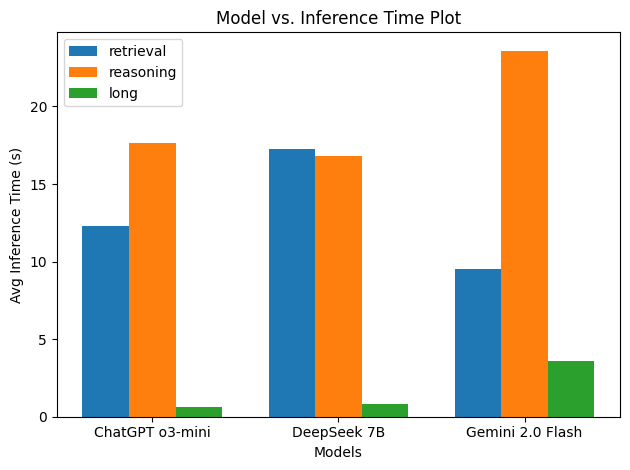

'\nprint("ChatGPT 03-mini average inference times:")\nprint(f"retrieval time: {avg_retrieval_time}")\nprint(f"reasoning time: {avg_reasoning_time}")\nprint(f"long prompt time: {avg_long_time}")\n\n# Plotting\nplt.bar(models, avg_retrieval_time[0], label=\'Avg Retrieval Time\')\nplt.bar(models, avg_reasoning_time[1], label=\'Avg Reasoning Time\')\nplt.bar(models, avg_long_time[2], label=\'Avg Long Time\')\n\n# Adding labels and title\nplt.xlabel(\'Models\')\nplt.ylabel(\'Avg Inference Time (s)\')\nplt.title(\'Model vs. Inference Time Plot\')\n\n# Show the plot\nplt.grid(True)\nplt.legend()\nplt.show()\n'

In [6]:
import matplotlib.pyplot as plt
import numpy as np

models = ["ChatGPT o3-mini", "DeepSeek 7B", "Gemini 2.0 Flash"]
avg_retrieval_time = [
    sum(retrieval_times[0])/len(retrieval_times[0]), 
    sum(retrieval_times[1])/len(retrieval_times[1]), 
    sum(retrieval_times[2])/len(retrieval_times[2])
]
avg_reasoning_time = [
    sum(reasoning_times[0])/len(reasoning_times[0]),
    sum(reasoning_times[1])/len(reasoning_times[1]),
    sum(reasoning_times[2])/len(reasoning_times[2])
]
avg_long_time = [
    sum(long_times[0])/len(long_times[0]),
    sum(long_times[1])/len(long_times[1]),
    sum(long_times[2])/len(long_times[2]),
]

x_entries = models
y_data = [
    avg_retrieval_time,
    avg_reasoning_time,
    avg_long_time
]

# Convert y_data to a NumPy array for easier manipulation
y_array = np.array(y_data)  # Shape: (n, 3)
n_groups = y_array.shape[0]
n_bars = y_array.shape[1]

# Bar positions
x = np.arange(n_groups)
bar_width = 0.25

# Offsets for each of the 3 bars
offsets = np.linspace(-bar_width, bar_width, n_bars)

# Plot
fig, ax = plt.subplots()
groups = ["retrieval", "reasoning", "long"]
for i in range(n_bars):
    ax.bar(x + offsets[i], y_array[:, i], width=bar_width, label=groups[i])

# X-axis settings
ax.set_xticks(x)
ax.set_xticklabels(x_entries)
ax.set_xlabel('Models')
ax.set_ylabel('Avg Inference Time (s)')
ax.set_title('Model vs. Inference Time Plot')
ax.legend()

plt.tight_layout()
plt.show()

'''
print("ChatGPT 03-mini average inference times:")
print(f"retrieval time: {avg_retrieval_time}")
print(f"reasoning time: {avg_reasoning_time}")
print(f"long prompt time: {avg_long_time}")

# Plotting
plt.bar(models, avg_retrieval_time[0], label='Avg Retrieval Time')
plt.bar(models, avg_reasoning_time[1], label='Avg Reasoning Time')
plt.bar(models, avg_long_time[2], label='Avg Long Time')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Avg Inference Time (s)')
plt.title('Model vs. Inference Time Plot')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()
'''

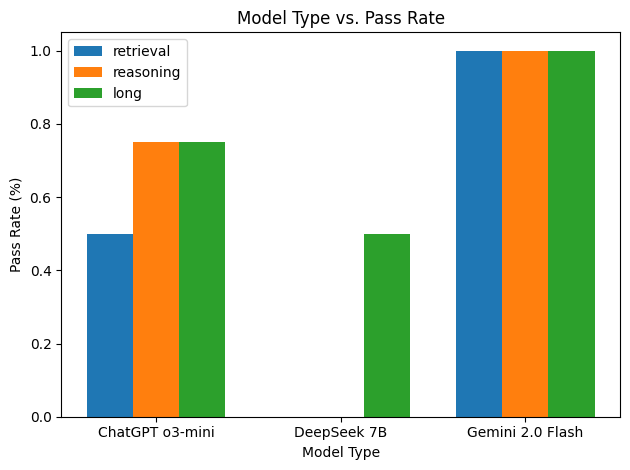

"\n# Plotting\nplt.bar(prompt_types, pass_rates)\n\n# Adding labels and title\nplt.xlabel('Prompt Type')\nplt.ylabel('Pass Rate (%)')\nplt.title('Model Type vs. Pass Rate')\n\n# Show the plot\nplt.show()\n"

In [7]:
# 0: gpt accuracy, 1: deepseek results, 2: gemini results
retrieval_pass_results = [[0, 1, 0, 1], [0, 0, 0, 0], [1, 1, 1, 1]]
reasoning_pass_results = [[1, 1, 1, 0], [0, 0, 0, 0], [1, 1, 1, 1]]
long_prompt_pass_results = [[1, 1, 0, 1], [0, 1, 0, 1], [1, 1, 1, 1]]

gpt_accuracy = [
    sum(retrieval_pass_results[0])/len(retrieval_pass_results[0]),
    sum(reasoning_pass_results[0])/len(reasoning_pass_results[0]),
    sum(long_prompt_pass_results[0])/len(long_prompt_pass_results[0])
]

deepseek_accuracy = [
    sum(retrieval_pass_results[1])/len(retrieval_pass_results[1]),
    sum(reasoning_pass_results[1])/len(reasoning_pass_results[1]),
    sum(long_prompt_pass_results[1])/len(long_prompt_pass_results[1])
]

long_accuracy = [
    sum(retrieval_pass_results[2])/len(retrieval_pass_results[2]),
    sum(reasoning_pass_results[2])/len(reasoning_pass_results[2]),
    sum(long_prompt_pass_results[2])/len(long_prompt_pass_results[2])
]

# x_entries are inferred from above
y_data = [gpt_accuracy, deepseek_accuracy, long_accuracy]

# Convert y_data to a NumPy array for easier manipulation
y_array = np.array(y_data)  # Shape: (n, 3)
n_groups = y_array.shape[0]
n_bars = y_array.shape[1]

# Bar positions
x = np.arange(n_groups)
bar_width = 0.25

# Offsets for each of the 3 bars
offsets = np.linspace(-bar_width, bar_width, n_bars)

# Plot
fig, ax = plt.subplots()
groups = ["retrieval", "reasoning", "long"]
for i in range(n_bars):
    ax.bar(x + offsets[i], y_array[:, i], width=bar_width, label=groups[i])

# X-axis settings
ax.set_xticks(x)
ax.set_xticklabels(x_entries)
ax.set_xlabel('Model Type')
ax.set_ylabel('Pass Rate (%)')
ax.set_title('Model Type vs. Pass Rate')
ax.legend()

plt.tight_layout()
plt.show()

'''
# Plotting
plt.bar(prompt_types, pass_rates)

# Adding labels and title
plt.xlabel('Prompt Type')
plt.ylabel('Pass Rate (%)')
plt.title('Model Type vs. Pass Rate')

# Show the plot
plt.show()
'''

## cosine similarity

In [41]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim(llm_responses, expected_answers):
    results = []
    
    for i in range(len(llm_responses)):
        # Convert strings to TF-IDF vectors
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([llm_responses[i], expected_answers[i]])
        
        # Calculate cosine similarity
        cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
        results.append(cosine_sim[0][0])

    return results

# infer model names

retrieval_prompts_exp = [
    "Lebron James scored 26 points against the Portland Trailblazers on October 18th, 2018.",
    "Steph Curry has won 4 championships in his career.",
    "Andre Iguodala missed 16 games in the 2016-2017 regular season.",
    "The top 3 overall teams in terms of standings at the end of the 1996-1997 regular season were the Chicago Bulls, Utah Jazz, and Houston Rockets."
]

reasoning_prompts_exp = [
    "If you add Lebron James' current career point total (as of the end of the 2023-2024 season, 40,474) with Kobe Bryant's career points total (33,643), you get 74,117 points.", # Using current known totals
    "The difference in regular season seed standing between the Miami Heat in the 2013 season (#1 seed) and the 2010 season (#5 seed) is 4 places (5 - 1).",
    "If you add Michael Jordan's highest scoring game (69 points) and Wilt Chamberlain's highest scoring game (100 points) point totals together, you get 169 points.",
    "Russell Westbrook has 1 MVP award and Kareem Abdul-Jabbar has 6 MVP awards, for a combined total of 7 MVP awards."
]

long_prompts_exp = [
    '''
    Based purely on the provided metrics (PPG, FG%, TS%), Joel Embiid scored more efficiently (65.5% TS%) than Luka Dončić (60.9% TS%) in the 2022-2023 season.
    True Shooting Percentage (TS%) provides a more comprehensive measure of scoring efficiency than Field Goal Percentage (FG%) because it accounts for free throws and three-pointers. It shows how many points a player scores per scoring attempt, giving a truer picture of efficiency across all types of shots, whereas FG% only considers made field goals relative to attempted field goals.
    ''',
    '''
    Based on Net Rating (Off Rating - Def Rating), the Grizzlies became a slightly less effective overall team in the 2022-2023 season (+4.0 Net Rating) compared to the 2021-2022 season (+5.4 Net Rating).
    Their identity shifted from a team strong on both offense (4th) and defense (6th) with a high net rating to a team whose identity leaned more heavily on an elite defense (3rd), while their offense dropped significantly in relative rank (11th), resulting in a lower net rating, despite maintaining a fast pace.
    ''',
    '''
    Nikola Jokić's league-leading VORP of 8.8 in 2022-2023 provides significant context to his impressive traditional stats (near triple-double averages) by quantifying his overall impact on winning. It shows that his broad statistical contributions translated directly into exceptional value for his team.
    A VORP of 8.8 specifically suggests that Jokić added approximately 8.8 wins to the Denver Nuggets' season total compared to what a readily available 'replacement-level' player would have contributed over the same playing time.
    ''',
    '''
    Based on the provided stats for the 2023-2024 season, Tyrese Haliburton (10.9 APG) primarily fulfilled the role of an elite playmaker and offensive initiator for the Pacers, focusing on setting up teammates while also scoring efficiently.
    Anthony Davis (12.6 RPG, 2.3 BPG), on the other hand, primarily served as an interior anchor for the Lakers, excelling in scoring close to the basket, dominating the glass, and providing significant rim protection as a defensive force.
    '''
]

gpt_similarity = [retrieval_responses[0], reasoning_responses[0], long_responses[0]]
deepseek_similarity = [retrieval_responses[1], reasoning_responses[1], long_responses[1]]
gemini_similarity = [retrieval_responses[2], reasoning_responses[2], long_responses[2]]

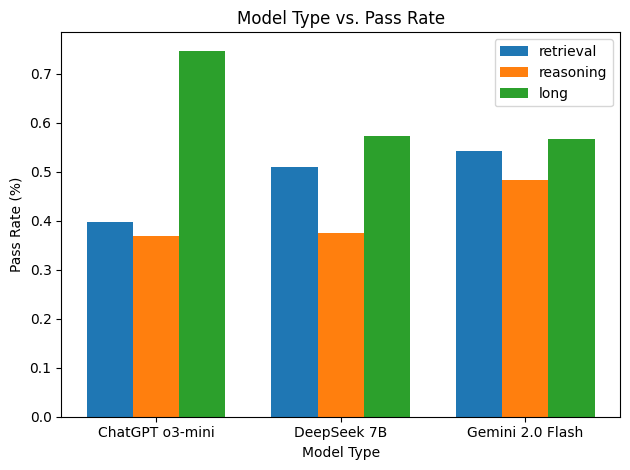

In [42]:
gpt_similarity[0] = cosine_sim(gpt_similarity[0], retrieval_prompts_exp)
deepseek_similarity[0] = cosine_sim(deepseek_similarity[0], retrieval_prompts_exp)
gemini_similarity[0] = cosine_sim(gemini_similarity[0], retrieval_prompts_exp)


gpt_similarity[1] = cosine_sim(gpt_similarity[1], reasoning_prompts_exp)
deepseek_similarity[1] = cosine_sim(deepseek_similarity[1], reasoning_prompts_exp)
gemini_similarity[1] = cosine_sim(gemini_similarity[1], reasoning_prompts_exp)


gpt_similarity[2] = cosine_sim(gpt_similarity[2], long_prompts_exp)
deepseek_similarity[2] = cosine_sim(deepseek_similarity[2], long_prompts_exp)
gemini_similarity[2] = cosine_sim(gemini_similarity[2], long_prompts_exp)

gpt_data = [
    sum(gpt_similarity[0])/len(gpt_similarity[0]),
    sum(deepseek_similarity[0])/len(deepseek_similarity[0]),
    sum(gemini_similarity[0])/len(gemini_similarity[0]),
]

deepseek_data = [
    sum(gpt_similarity[1])/len(gpt_similarity[1]),
    sum(deepseek_similarity[1])/len(deepseek_similarity[1]),
    sum(gemini_similarity[1])/len(gemini_similarity[1]),
]

gemini_data = [
    sum(gpt_similarity[2])/len(gpt_similarity[2]),
    sum(deepseek_similarity[2])/len(deepseek_similarity[2]),
    sum(gemini_similarity[2])/len(gemini_similarity[2]),
]

y_data = [gpt_data, deepseek_data, gemini_data]

# Convert y_data to a NumPy array for easier manipulation
y_array = np.array(y_data)  # Shape: (n, 3)
n_groups = y_array.shape[0]
n_bars = y_array.shape[1]

# Bar positions
x = np.arange(n_groups)
bar_width = 0.25

# Offsets for each of the 3 bars
offsets = np.linspace(-bar_width, bar_width, n_bars)

# Plot
fig, ax = plt.subplots()
groups = ["retrieval", "reasoning", "long"]
for i in range(n_bars):
    ax.bar(x + offsets[i], y_array[:, i], width=bar_width, label=groups[i])

# X-axis settings
ax.set_xticks(x)
ax.set_xticklabels(x_entries)
ax.set_xlabel('Model Type')
ax.set_ylabel('Pass Rate (%)')
ax.set_title('Model Type vs. Pass Rate')
ax.legend()

plt.tight_layout()
plt.show()